### Final Semantle RL Algorithm

# Import Libraries

In [166]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from nltk import FreqDist, download
from nltk.corpus import words, brown, stopwords
import nltk
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import kmeans_plusplus
import numpy as np
import scipy

# Download corpora and Word2Vec model

In [168]:
download('words')
download('brown')
download('stopwords')
embedding_model = api.load('word2vec-google-news-300')


[nltk_data] Downloading package words to
[nltk_data]     /Users/francisfurnelli/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/francisfurnelli/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francisfurnelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Form word list
We used the brown corpus to identify 20,000 most common tokens, and then kept only English non-stopwords.

In [216]:
english = words.words()
frequency_list = FreqDist(word for word in brown.words() if word.islower())
brown_most_common = [word for word,_ in frequency_list.most_common(20000)]
most_common = [word for word in brown_most_common if word in embedding_model and word in english and word not in stopwords.words()]

In [217]:
print(len(most_common))

12259


# Create Semantle Environment
This class houses all of the logic for playing the Semantle game

In [ ]:
""" This class is a Gymnasium Environment for Semantle, similar to Thomas' MDP """
import scipy.special


class SemantleEnv(gym.Env):
    def __init__(self, target_words, embedding_model=None, target_word=None):
        super(SemantleEnv, self).__init__()
        self.target_words = target_words
        if embedding_model == None:
            embedding_model = api.load('word2vec-google-news-300')
        self.embedding_model = embedding_model  # e.g., a Word2Vec or BERT wrapper
        
        self.word_list = most_common.copy()
        if target_word == None or target_word not in self.target_words:
            target_word = random.sample(self.target_words, k=1)[0]
        self.target_word = target_word
        self.target_vector = self.get_embedding(target_word)

        self.action_space = spaces.Discrete(6)
        #self.action_space = spaces.Discrete(len(self.word_list))  # index of word list
        #self.observation_space = spaces.Box(low=-1.,high=1.,shape=(300,))
        self.observation_space = spaces.Dict({#'current_embedding': spaces.Box(low=-1., high=1., shape=(300,), dtype=np.float32), 
                                               #'score': spaces.Box(low=-1., high=1., dtype=np.float32),
                                               #'best_embedding': spaces.Box(low=-1., high=1., shape=(300,), dtype=np.float32),
                                               'max_score': spaces.Box(low=-1., high=1., dtype=np.float32),})
        #                                       'delta_score': spaces.Box(low=-1., high=1., dtype=np.float32),
                                               #'number_of_guesses': spaces.Box(low=0, high=300)})
        # self.observation_space = spaces.Dict({'best_embedding': spaces.Box(low=-1., high=1., shape=(300,), dtype=np.float32),
        #                                       'max_score': spaces.Box(low=-1., high=1., dtype=np.float32),
        #                                       'number_of_guesses': spaces.Box(low=0, high=300)})
        self.knn = NearestNeighbors(n_neighbors=1, algorithm='auto', metric="cosine")
        self.knn.fit(self.embedding_model[self.word_list])
        self.top1000 = []
        self.state = []
        self.guess_history = []
        self.best = None

    def get_embedding(self, word):
        return self.embedding_model[word]
    
    def sample_target_word(self):
        return random.sample(self.target_words, k=1)[0]

    def compute_similarity(self, vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    def reset(self, target=None, seed=None, options=None):
        self.guess_history = []
        self.target_word = target if target != None and target in self.embedding_model else self.sample_target_word()
        self.target_vector = self.get_embedding(self.target_word)
        self.word_list = most_common.copy()
        # self.knn.fit(self.embedding_model[self.word_list])
        # distances, indices = self.knn.kneighbors(self.target_vector.reshape(1,-1), n_neighbors=1000)
        # self.top1000 = [self.word_list[i] for i in indices[0]]
        # print(self.target_word)
        # print(self.top1000)
        # raise Exception
        print("\n======================")
        print(self.target_word)
        self.state = {#'current_embedding': np.zeros((300,)), 
                         #'score': np.array([-1]),
                         #'best_embedding': np.zeros((300,)),
                         'max_score': np.array([-1]),}
        #                 'delta_score': np.array([0]),
                         #'number_of_guesses': np.array([0])}
        
        #self.state = np.zeros(self.observation_space.shape)
        self.best = None
        return self.state, {}

    def step(self, action):
        #print(f"Explore {action}" if action == 0 else f"Exploit {action}")
        N_CLUSTERS = 8 # How many clusters (basically how diverse)
        THRESHOLD = 0.5 # Lower bound for similarity to best guess so far
        NNeighbors = 8 # How many nearest neighbors to compute
        K = 4 # How many of the nearest neighbors to randomly sample
        embeddings = self.embedding_model[self.word_list]
        self.knn.fit(embeddings)
        guess = None
        if action == 0: # Explore
            guess = random.sample(self.word_list, k=1)[0]
        else: # Exploit
            NNeighbors = [4,3,2,1,0][action-1] #1-6 works pretty well
            best_embedding = self.get_embedding(self.best[0]) if self.best != None else (np.random.random((300,))-0.5)*2
            distances, indices = self.knn.kneighbors(best_embedding.reshape(1,-1), n_neighbors=min(2**NNeighbors, len(self.word_list)))
            indices_to_words = [self.word_list[id] for id in indices[0]]
            #probs = scipy.special.softmax(distances[0])
            guess = random.choices(indices_to_words, k=1)[0]
        guess_vector = self.get_embedding(guess)
        similarity = self.embedding_model.similarity(guess, self.target_word)#self.compute_similarity(guess_vector, self.target_vector)
        print(f'guess: {guess}, sim: {similarity}')
        self.guess_history.append((guess, similarity))
        prev_best = self.best[1] if self.best != None else 0
        if self.best == None or similarity > self.best[1]: 
            self.best = (guess,similarity)
        self.state = {#'current_embedding': guess_vector, 
                        #'score': np.array([similarity], dtype=float),
                        #'best_embedding': self.get_embedding(self.best[0]),
                        'max_score': np.array([self.best[1]], dtype=float),}
                        #'delta_score': np.array([delta], dtype=float),
                         #'number_of_guesses': np.array([len(self.guess_history)], dtype=float)}
        self.word_list.remove(guess)
        ## Reward Modeling
        reward = 0
        if similarity >= 0.99: # Guess is correct
            reward = 1000
        elif similarity >= 0.1 and similarity - prev_best >= 0: # Guess improves
            reward = 0#(similarity * 10)**3
        else: 
            reward = 0
        #print(reward)
        terminated = similarity >= 0.99
        truncated = len(self.guess_history) == 200

        return self.state, reward, terminated, truncated, {}

    def render(self):
        if self.guess_history:
            print(f"Guesses: {self.guess_history[-5:]}")

    def close(self):
        pass

# Import Target Words

In [ ]:
import pandas
df = pandas.read_csv("semantle.csv") # Pull in target words
target_words = df['answer'].to_list()

# Training: Run PPO for Semantle

In [248]:
from stable_baselines3 import PPO, DQN, A2C, DDPG, TD3, SAC
from stable_baselines3.common.noise import NormalActionNoise
env = SemantleEnv(target_words=target_words, embedding_model=embedding_model)
#model = PPO("MultiInputPolicy", env, verbose=1, gamma=0.99)
model = PPO("MultiInputPolicy", env, verbose=1,gamma=0.9)
model.learn(total_timesteps=5000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

shame
guess: electrocardiograph, sim: 0.0033027506433427334
guess: manometer, sim: -0.02061327174305916
guess: sensor, sim: 0.06129153445363045
guess: device, sim: 0.05624997615814209
guess: transducer, sim: -0.012480249628424644
guess: inertial, sim: -0.0030941017903387547
guess: engraved, sim: 0.10538636147975922
guess: plaque, sim: 0.12734095752239227
guess: monument, sim: 0.18328022956848145
guess: statue, sim: 0.14127452671527863
guess: analyst, sim: 0.013722358271479607
guess: cemetery, sim: 0.1448940932750702
guess: obelisk, sim: 0.07607555389404297
guess: edifice, sim: 0.1821492314338684
guess: tomb, sim: 0.12002889811992645
guess: sculpture, sim: 0.03164913132786751
guess: memorial, sim: 0.1738494634628296
guess: chapel, sim: 0.11366336792707443
guess: fountain, sim: 0.11513751745223999
guess: mausoleum, sim: 0.13602948188781738
guess: museum, sim: 0.08521055430173874
guess: shrine, 

# Testing using Unseen Test Data
Displays statistics at the end

In [261]:
test_set = random.sample(most_common, k=110)
test_set = [word for word in test_set if word not in target_words][:100]
results = []
results_wins = []
for target in test_set:
    obs, info = env.reset(target)
    print(f"Target: {env.target_word}")
    done, truncated = False, False
    while not (done or truncated):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            env.render()
            print(f'Guesses {len(env.guess_history)}')
            results.append(len(env.guess_history))
            if done: results_wins.append(len(env.guess_history))
            print("\n==============")
print(f"Average episode len: {np.mean(results)}")
print(f"Standard Deviation of episode length: {np.std(results)}")
print(f"Median episode length: {np.median(results)}")
print(f"Wins within 50: {len([x for x in results if x <= 50])} out of 100")
print(f"Wins within 100: {len([x for x in results if x <= 100])} out of 100")
print(f"Wins within 200: {len(results)} out of 100")
print(f"Minimum episode length: {np.min(results)}")
print(f"Maximum episode length: {np.max(results) if len(results) < 100 else 200}")
print(f"Average guesses to win: {np.mean(results_wins)}")
print(f"Standard Deviation of wins: {np.std(results_wins)}")
print(f"Median guesses to win: {np.median(results_wins)}")
env.close()


drawing
Target: drawing
guess: elongation, sim: -0.018513143062591553
guess: flexural, sim: 0.053292058408260345
guess: chamfer, sim: 0.1074819341301918
guess: beveled, sim: 0.036858946084976196
guess: tappet, sim: 0.05279548838734627
guess: radial, sim: 0.03171062096953392
guess: horizontal, sim: 0.12254554033279419
guess: horizontally, sim: 0.10692660510540009
guess: vertically, sim: 0.05214498192071915
guess: diagonally, sim: 0.08171956241130829
guess: diagonal, sim: 0.13565106689929962
guess: rectangle, sim: 0.14826078712940216
guess: rectangular, sim: 0.12125415354967117
guess: lengthwise, sim: 0.024128934368491173
guess: curved, sim: 0.11648479104042053
guess: concave, sim: 0.04672819748520851
guess: octagonal, sim: 0.08986151963472366
guess: cylindrical, sim: 0.08492531627416611
guess: triangle, sim: 0.09133325517177582
guess: featureless, sim: 0.07595761865377426
guess: expanse, sim: 0.033610329031944275
guess: translucent, sim: 0.07203423231840134
guess: contour, sim: 0.13343

Wins within 200: 94 out of 100


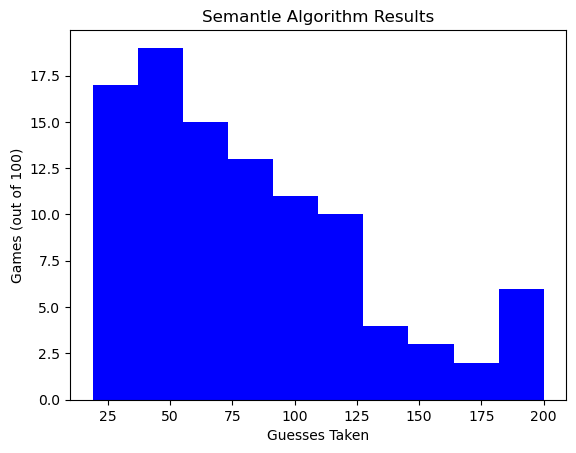

In [264]:
import matplotlib.pyplot as plt
print(f"Wins within 200: {len(results_wins)} out of 100")
plt.hist(results, bins=10, color="blue")
plt.title("Semantle Algorithm Results")
plt.xlabel("Guesses Taken")
plt.ylabel("Games (out of 100)")
plt.savefig("semantle-results.png")

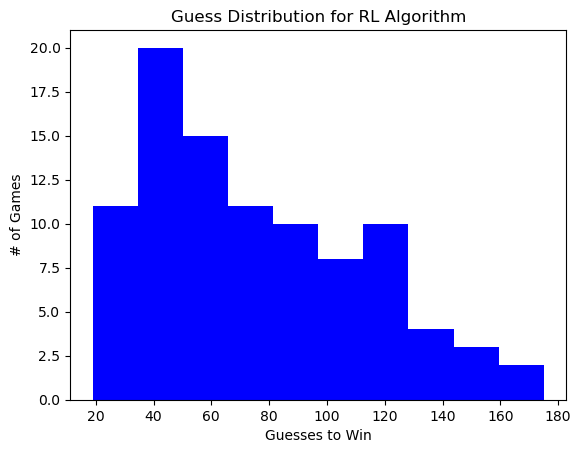

In [269]:
plt.hist(results_wins, bins=10, color="blue")
plt.title("Guess Distribution for RL Algorithm")
plt.xlabel("Guesses to Win")
plt.ylabel("# of Games")
plt.savefig("semantle-results-wins-only.png")